In [1]:
import numpy as np
import pandas as pd
from final_processing import final_processing_functions as fpf
import pathlib
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import rcParams
import yaml
import figure_formatting as ff
from scipy.stats import pearsonr
import matplotlib
warnings.filterwarnings('ignore')
%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/

In [2]:
with open("general_analysis_parameters.yaml", "r") as file:
    gen_parameters = yaml.safe_load(file)
rcParams['font.sans-serif'] = gen_parameters['font']
rcParams['font.family'] = gen_parameters['font']
rcParams['font.size'] = gen_parameters['font_size']
font_size = gen_parameters['font_size']
saving_path = gen_parameters['fig_saving_path']
mice = gen_parameters['MICE']
proj_path = gen_parameters['proj_path']

# saving_path = '/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/figs'
# mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_dict = {}
area_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"{proj_path}/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    lcm_dir =  pathlib.Path(
    f"{proj_path}/{mouse}/LCM")
    area_dict[mouse] = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=lcm_dir, area_threshold=0,
    )
    barcodes = fpf.add_prefix_to_index(barcodes, mouse)
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['area_is_main']= fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['max_counts'] = barcodes.max(axis=1)
    combined_dict[mouse] = new_dict


In [3]:
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
all_mice = {}
for i, key in enumerate(analysis_names):
    common_columns = fpf.get_common_columns(mice=mice, combined_dict=combined_dict, key=key, cortex=False)
    all_mice[key] = pd.concat([
    combined_dict[k][key][common_columns]
    for k in mice
])
    #all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns], combined_dict['FIAA55.4d'][key][common_columns]], ignore_index=False)
    

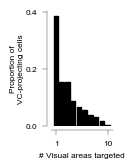

In [4]:

matplotlib.rcParams["pdf.fonttype"] = 42

key='homogenous_across_cubelet'
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
#data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
data = vis_proj[vis_adj].astype(bool).sum(axis=1)
fig, ax = plt.subplots(figsize=(0.8, 1.5))  
counts = np.bincount(data, minlength=11)

ax.bar(np.arange(11)[1:], counts[1:] / np.sum(counts), color='black',edgecolor='black')
ax.set_xticks([1, 10])
ax.set_yticks([0.0, 0.2, 0.4])
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= 'Proportion of\nVC-projecting cells', xtitle='# Visual areas targeted', title='', mySize =font_size)
# ax.set_xlabel('# visual areas targeted')
# ax.set_ylabel('Proportion of\nVC-projecting cells')
# sb.despine(ax=ax, offset=5)
# ax.tick_params(width=0.25)
# for line in ["left","bottom"]:
#     ax.spines[line].set_linewidth(0.25)
max_counts_list = [data["max_counts"] for data in combined_dict.values()]

# Concatenate all 'max_counts' dataframes
concatenated_max_counts = pd.concat(max_counts_list, ignore_index=False)
max_counts = concatenated_max_counts.loc[vis_proj[vis_adj].index]
saving_path = '/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/figs'
fig.savefig(f"{saving_path}/vc_projection_counts.pdf", format="pdf")
fig.savefig(f"{saving_path}/vc_projection_counts.svg", format="svg")

In [ ]:
#supp figure showing how max cubelet barcode count per barcode changes with number of visual areas targeted
fig, ax = plt.subplots(figsize=(2.2, 2.2))
df = pd.DataFrame({"x": data, "y": np.log2(max_counts)})
sb.barplot(x="x", y="y", data=df, alpha=0.6, color="purple", ci=None)

sb.stripplot(x="x", y="y", data=df, color="black", alpha=0.1, jitter=True)
# plt.xlabel("# visual areas targeted")
# plt.ylabel("log2(max count)")
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= 'Log$_{2}$(max count)', xtitle='# Visual areas targeted', title='', mySize =font_size)
fig.savefig(f"{saving_path}/supplementary/extended_fig_3b_change_in_vis_areas_versus_max_count.svg", format="svg")
fig.savefig(f"{saving_path}/supplementary/extended_fig_3b_change_in_vis_areas_versus_max_count.pdf", format="pdf")
plt.show()


In [ ]:

# layers = ['upper', 'lower']
# mouse_layer_dict = {}
# for num, mouse in enumerate(mice):
#     new_dict = {}
#     parameters_path = (
#     f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
#     barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
#     parameters = fpf.load_parameters(directory=parameters_path)
#     sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
#     sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
#     sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
#     AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
#     AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
#     for layer in layers:
#         area_dict = {}
#         barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
#         barcodes_new = barcodes_new[
#             (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
#             (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
#             (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
#         ]
#         area_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
#        # missing_cols = set(all_mice[key].columns) - set(area_dict['area_is_main'].columns) #since there is some zero values for regions that are looked at
#         #for col in missing_cols:
#         #    area_dict['area_is_main'][col] = 0
#         area_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False)
#         area_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False)
#         new_dict[f'{layer}_layer'] = area_dict
#         # print(f"Creating barcodes for {layer} layer in {mouse}")
#         # print(area_dict['homogenous_across_area'])
    
#     mouse_layer_dict[mouse] = new_dict


In [ ]:
# def add_mouse_layer(df, mouse_label, layer_label):
#     df['Mouse'] = mouse_label
#     df['Layer'] = layer_label
#     return df
# visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
# key = 'homogenous_across_cubelet'
# new_layer_dict = {}
# for mouse in mice:
#     mini_dict = {}
#     for layer in layers:
#         mini_dict[f'{layer}_layer'] = mouse_layer_dict[mouse][f'{layer}_layer'][key][visual_areas].astype(bool).astype(int)
#         mini_dict[f'{layer}_layer'] = add_mouse_layer(mini_dict[f'{layer}_layer'], mouse, layer)
#     concatenated_df = pd.concat(mini_dict.values(), axis=0, ignore_index=False)
#     new_layer_dict[mouse] = concatenated_df
# combined_df = pd.concat(new_layer_dict.values(), axis=0, ignore_index=False)
# combined_df = combined_df.dropna(axis=1, how='any')

In [ ]:

# results = {}
# df = combined_df.melt(id_vars=['Mouse', 'Layer'], var_name='Area', value_name='Projection')
# pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])
# for area in visual_areas:
#     df_area = df[df['Area'] == area]
#     model = smf.logit('Projection ~ Layer + Mouse', data=df_area).fit(disp=False)
#     results = model.summary2().tables[1]
#     pval_df.loc[area, 'p_value'] = results.loc['Layer[T.upper]', 'P>|z|']
#     pval_df.loc[area, 'OR'] = np.exp(results.loc['Layer[T.upper]', 'Coef.'])

# pval_df['p_value_corrected'] = pval_df['p_value']*len(pval_df)
# summary_df = pd.DataFrame(index = mice, columns = visual_areas)
# for mouse in mice:
#     dff = new_layer_dict[mouse]
#     for area in visual_areas:
#         freq_upper = dff[dff['Layer']=='upper'][area].mean()
#         freq_lower = dff[dff['Layer']=='lower'][area].mean()
#         summary_df.loc[mouse, area] = freq_upper/freq_lower
# visual_areas = summary_df.columns


In [ ]:
# pval_df = fpf.convert_matrix_names(pval_df)
# summary_df = fpf.convert_matrix_names(summary_df)
# new_order = ['LM', 'LI', 'POR', 'P', 'AL', 'V1', 'AM', 'A', 'PM', 'RL']
# summary_df = summary_df[new_order]

In [ ]:
# fig, ax = plt.subplots(figsize=(2.5, 2))  # Adjusted figure size for better layout
# area_means = summary_df.mean(axis=0)
# max_value = summary_df.max().max()
# sb.barplot(x=new_order, y=area_means, color='black', ci=None, width=0.9, zorder=1)
# for i, area in enumerate(new_order):
#     for mouse in summary_df.index:
#         plt.scatter(
#             i, 
#             summary_df.loc[mouse, area], 
#             color='grey', s=20, zorder=2
#         )
# heights = []
# for i, area in enumerate(new_order):
#     asterisk_height = summary_df[area].max() + 0.1  
#     p_value = pval_df.loc[area, 'p_value_corrected']  
#     if p_value <= 0.001:
#         asterisk = '***'
#     elif p_value <= 0.01:
#         asterisk = '**'
#     elif p_value <= 0.05:
#         asterisk = '*'
#     else:
#         asterisk = None  # No asterisk if p > 0.05
    
#     if asterisk:  # Add asterisk if significance is present
#         plt.text(
#             i,  
#             asterisk_height,
#             asterisk, 
#             ha='center', va='bottom', fontsize=16, color='black', weight='bold'
#         )
#         heights.append(asterisk_height)
# plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
# plt.xticks(rotation=90)
# plt.ylim(0, np.max(heights) + 0.5) 
# ylabel = 'Upper vs Deep Layer A1 Neuron \n Targeting Frequency'
# ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= ylabel, xtitle='', title='', mySize =7)
# fig.savefig(f"{saving_path}/supplementary/upper_vs_deep.svg", format="svg")
# plt.tight_layout()
# plt.show()

In [ ]:
# mcc = MouseConnectivityCache()
# structure_tree = mcc.get_structure_tree()
# rsp = mcc.get_reference_space()
# plt.rcParams["font.size"] = 5
# a1_dist_dict = {}
# visual_areas = ['VISli', 'VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
# HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)
# # HVA_colors_updated = {
# #     'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
# #     'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
# #     'VISam': '#C2543C', 'VISpm': '#D7716C'
# # }

# structure = structure_tree.get_structures_by_acronym(['AUDp'])
# structure_id = structure[0]['id']
# mask = rsp.make_structure_mask([structure_id], direct_only=False)
# A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# fig, axes = plt.subplots(2, 1, figsize=(1.2, 3), sharex=True)

# plt.subplots_adjust(hspace=0.5)  # Increases vertical spacing between subplots

# def exponential_decay(x, a, b):
#     return a * np.exp(-b * x)

# key_to_plot = 'homogenous_across_cubelet'
# areas = all_mice[key_to_plot].columns.drop(['Contra', 'AUDp'])
# vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

# distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
# for col in areas:
#     structure = structure_tree.get_structures_by_acronym([col])
#     structure_id = structure[0]['id']
#     mask = rsp.make_structure_mask([structure_id], direct_only=False)
#     vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
#     distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

# a1_dist_dict[key_to_plot] = distance_from_a1

# freq_df = pd.DataFrame(columns=areas, index=mice)
# freq_df_strength = pd.DataFrame(columns=areas, index=mice)
# for mouse in mice:
#     freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key_to_plot])
#     freq_df_strength.loc[mouse] = combined_dict[mouse][key_to_plot][areas].where(combined_dict[mouse][key_to_plot][areas] > 0).mean(axis=0)
# distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
# distances = pd.to_numeric(distances, errors='coerce')
# for which_one, which_type in enumerate([freq_df, freq_df_strength]):
#     means = pd.to_numeric(which_type.mean(), errors='coerce')
#     errors = pd.to_numeric(which_type.std(), errors='coerce')

#     if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
#         try:
#             params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))
#             fitted_x = np.linspace(min(distances), max(distances), 100)
#             fitted_y = exponential_decay(fitted_x, *params)
#             what_plot = axes[which_one].plot(fitted_x, fitted_y, color='k', linestyle='dotted', label='Exponential Fit')
            
#             fitted_values = exponential_decay(distances.values, *params)
#             ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
#             print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")

#         except Exception as e:
#             print(f"Error fitting exponential curve for key {key_to_plot}: {e}")

#     for area in areas:
#         color = HVA_colors_updated.get(area, 'lightgrey')
#         axes[which_one].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', color='black', mfc=color, mec=color, capsize=3, markersize=2, elinewidth=0.5)
#         # axes[1].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black', mfc=color, mec=color, capsize=5)
#     ff.myPlotSettings_splitAxis(fig=what_plot, ax=axes[which_one], ytitle= '', xtitle='Distance from A1 (µm)', title='', mySize =5)
# axes[0].set_ylabel('Frequency of Targeting')
# axes[1].set_ylabel('Mean Projection Strength')
# axes[0].tick_params(labelbottom=True)
# convert_dict = ff.get_convert_dict()

# visual_legend_elements = [
#     Line2D([0], [0], marker='o', color='w', 
#            label=convert_dict.get(area, area),  # Convert name using dictionary
#            markerfacecolor=color, markersize=4, linestyle='None')
#     for area, color in HVA_colors_updated.items()
# ]

# fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=5, prop={'family': 'Arial'})
# # visual_legend_elements = [
# #     Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor=color, markersize=8, linestyle='None')
# #     for area, color in HVA_colors_updated.items()
# # ]

# # fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)

# for ax in axes:
#     ax.legend(loc='upper right', fontsize=5)
# #fig.savefig(f"{saving_path}/fig2_dist_vs_proj.svg", format="svg")
# plt.show()

KS Statistic: 0.15384615384615385, p-value: 0.9260194717268708, legnth scale: 857.0321140997705
Correlation: 0.7696180427012398, p-value: 4.306293979889409e-06
KS Statistic: 0.23076923076923078, p-value: 0.5009952475373968, legnth scale: 1352.2339607317472
Correlation: 0.6925876861497703, p-value: 8.819998030915137e-05


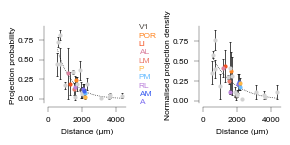

In [7]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()

a1_dist_dict = {}
visual_areas = ['VISli', 'VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
HVA_colors_updated = ff.get_colour_dict(allen_nomenclature=True)

structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))
# fig, axes = plt.subplots(1, 2, figsize=(2.2, 1.2))
fig, axes = plt.subplots(1, 2, figsize=(3, 1)) 
plt.subplots_adjust(wspace=1)
#plt.subplots_adjust(hspace=0.5)  # Increases vertical spacing between subplots

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

key_to_plot = 'homogenous_across_cubelet'
areas = all_mice[key_to_plot].columns.drop(['Contra', 'AUDp'])
vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
for col in areas:
    structure = structure_tree.get_structures_by_acronym([col])
    structure_id = structure[0]['id']
    mask = rsp.make_structure_mask([structure_id], direct_only=False)
    vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
    distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

a1_dist_dict[key_to_plot] = distance_from_a1

freq_df = pd.DataFrame(columns=areas, index=mice)
freq_df_strength = pd.DataFrame(columns=areas, index=mice)
for mouse in mice:
    freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key_to_plot])
    freq_df_strength.loc[mouse] = combined_dict[mouse][key_to_plot][areas].where(combined_dict[mouse][key_to_plot][areas] > 0).mean(axis=0)
freq_df_strength= freq_df_strength# no need anymore to convert *1e9 #convert to mm3
distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
distances = pd.to_numeric(distances, errors='coerce')
for which_one, which_type in enumerate([freq_df, freq_df_strength]):
    means = pd.to_numeric(which_type.mean(), errors='coerce')
    errors = pd.to_numeric(which_type.std(), errors='coerce')

    if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
        try:
            params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))
            fitted_x = np.linspace(min(distances), max(distances), 100)
            fitted_y = exponential_decay(fitted_x, *params)
            what_plot = axes[which_one].plot(
                fitted_x, 
                fitted_y, 
                color='black', 
                linewidth=0.5, 
                linestyle='dotted',
                label=f'Exponential\nFit'
            )
            fitted_values = exponential_decay(distances.values, *params)
            ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
            print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}, legnth scale: {1/params[1]}")

            # make cross-validated predictions by holding out one value at a time
            for i in range(len(distances)):
                # Create a mask for all indices except the current one
                mask = np.ones(len(distances), dtype=bool)
                mask[i] = False
                # Calculate the fitted value for the current index
                params, _ = curve_fit(exponential_decay, distances.values[mask], means.values[mask], p0=(max(means), 0.001))
                # Store the fitted value in the array
                fitted_values[i] = exponential_decay(distances.values[i], *params)

            # quantify the goodness of fit as the correlation between the observed and fitted values
            correlation, correlation_p_value = pearsonr(means.values, fitted_values)
            print(f"Correlation: {correlation}, p-value: {correlation_p_value}")


        except Exception as e:
            print(f"Error fitting exponential curve for key {key_to_plot}: {e}")

    for area in areas:
        color = HVA_colors_updated.get(area, 'lightgrey')
        axes[which_one].errorbar(
            distances[area], 
            means[area], 
            yerr=errors[area], 
            fmt='o',
            color='black', 
            mfc=color, 
            mec=color, 
            capsize=0.5,
            capthick=0.5,
            markersize=2, 
            elinewidth=0.5
        )
        # axes[1].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black', mfc=color, mec=color, capsize=5)
    ff.myPlotSettings_splitAxis(fig=what_plot, ax=axes[which_one], ytitle= '', xtitle='Distance (µm)', title='', mySize =font_size)
axes[0].set_ylabel('Projection probability', fontsize=font_size,
                    fontfamily ='Arial')
axes[1].set_ylabel('Normalised projection density', fontsize=font_size,
                    fontfamily ='Arial')
#axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
axes[0].tick_params(labelbottom=True)
convert_dict = ff.get_convert_dict()
# visual_legend_elements = [
#     Line2D([0], [0], marker='o', color='w', 
#            label=convert_dict.get(area, area),  # Convert name using dictionary
#            markerfacecolor=color, markersize=3, linestyle='None')
#     for area, color in HVA_colors_updated.items()
# ]

# fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=font_size, prop={'family': 'Arial'}, frameon =False)#since we have the fig legend in the other plots
labels = [convert_dict.get(a, a) for a in HVA_colors_updated]

dummy_handles = [Line2D([], [], linestyle='None', marker=None)  
                 for _ in labels]

legend = fig.legend(dummy_handles, labels,
                    loc='center left',
                    bbox_to_anchor=(0.4, 0.5),   
                    frameon=False,
                    handlelength=0,              
                    handletextpad=0.1,           
                    labelspacing=0.18,            
                    fontsize=font_size,
                    prop={'family': 'Arial'})


for txt, area in zip(legend.get_texts(), HVA_colors_updated):
    txt.set_color(HVA_colors_updated[area])

if hasattr(legend, "legend_handles"):             # versions ≥3.7
    for h in legend.legend_handles:
        h.set_visible(False)
# visual_legend_elements = [
#     Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor=color, markersize=8, linestyle='None')
#     for area, color in HVA_colors_updated.items()
# ]

# fig.legend(handles=visual_legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)

for ax in axes:
#     ax.legend(loc='upper right', fontsize=font_size,bbox_to_anchor=(1.5, 1.2),frameon=False)
    #  ax.set_xlim(left=0)
    ax.set_xticks([0, 2000, 4000])

fig.savefig(f"{saving_path}/fig2_dist_vs_proj.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_dist_vs_proj.pdf", format="pdf")


In [ ]:
#what is the mean volume of ipsi cortical projections?
volumes = []
for mouse in mice:
     lcm_dir =  pathlib.Path(
    f"{proj_path}/{mouse}/LCM")
     parameters_path = f'{proj_path}/{mouse}/Sequencing'
     parameters = fpf.load_parameters(directory=parameters_path)
     sample_vol_and_regions = pd.read_pickle(
        lcm_dir / "sample_vol_and_regions.pkl"
    )
     ipsi_cortex = [sample for sample in parameters['cortical_samples'] if sample not in parameters['contra']]
     which_table = sample_vol_and_regions[sample_vol_and_regions['ROI Number'].isin(ipsi_cortex)]

     #vols = which_table['vol_in_atlas'].to_list()
     vols = which_table['Volume (um^3)'].to_list()
     volumes.extend(vols)
mean_vol = np.mean(volumes)
# SEM_micron = np.std(volumes)/np.sqrt(len(volumes))
mean_vol_cubic_mm = mean_vol * 1e-9
SD_mm= (np.std(volumes))* 1e-9
print(f'mean vol = {mean_vol_cubic_mm} mm3 +- {SD_mm}')

In [ ]:
# mouse = 'FIAA55.4d'
# parameters_path = pathlib.Path(f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
# parameters = ps.load_parameters(directory=str(parameters_path))
# sample_vol_path = parameters['lcm_directory']+'/sample_vol_and_regions.pkl'
# fpf.get_main_region(sample_vol=sample_vol_path, parameters_path= str(parameters_path), use_slurm=True, slurm_folder="/camp/home/turnerb/slurm_logs")